In [1]:
"""! pip install datasets
! pip install matplotlib
! pip install scikit-learn
! pip install spacy
! pip install nltk
! pip install pattern
! pip install wordcloud
! pip install gensim
! pip install xgboost
# ! python -m spacy download pt_core_news_sm
! python -m spacy download pt_core_news_lg"""

'! pip install datasets\n! pip install matplotlib\n! pip install scikit-learn\n! pip install spacy\n! pip install nltk\n! pip install pattern\n! pip install wordcloud\n! pip install gensim\n! pip install xgboost\n# ! python -m spacy download pt_core_news_sm\n! python -m spacy download pt_core_news_lg'

In [2]:
from sklearn.metrics import classification_report, f1_score, hamming_loss, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from nltk.stem import SnowballStemmer
from gensim.models import Word2Vec
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import re


/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Data Loading and Understanding**

In [3]:
dataset = load_dataset("higopires/RePro-categories-multilabel")

In [4]:
# Ver número de exemplos em cada divisão do dataset
for split in dataset.keys():
    print(f"{split}: {len(dataset[split])} examples")

train: 8002 examples
validation: 994 examples
test: 1007 examples


In [5]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

train_data = pd.DataFrame(train_dataset)
val_data = pd.DataFrame(val_dataset)
test_data = pd.DataFrame(test_dataset)

In [6]:
train_data.head()

,review_text,ENTREGA,OUTROS,PRODUTO,CONDICOESDERECEBIMENTO,INADEQUADA,ANUNCIO
0,"Aparelho muito bom, confiável e com valor aqui...",0,0,1,0,0,0
1,"A história é muito boa, porém o autor ""enrolou...",0,0,1,0,0,0
2,"Entrega rápida, produto muito bom Amei. Pratic...",1,0,1,0,0,0
3,Produto otimo so falta o carregador da maquina...,0,0,1,1,0,0
4,a proteção anti queda não é boa se cair de fr...,0,0,1,0,0,0


Checking the missing values

In [7]:
train_data.isnull().sum()

review_text               0
ENTREGA                   0
OUTROS                    0
PRODUTO                   0
CONDICOESDERECEBIMENTO    0
INADEQUADA                0
ANUNCIO                   0
dtype: int64

Example of some reviews

In [8]:
print(train_data["review_text"][2])

Entrega rápida, produto muito bom Amei. Praticidade


In [9]:
print(train_data["review_text"][7])

...................     ..........gdssdfhhbcxxxxvbjjnvvvvbbbbbvxfvhbbbnncftg


In [10]:
# check data type of review_text
print(type(train_data["review_text"][0]))
# check data type of label PRODUTO
print(type(train_data["PRODUTO"][0]))

<class 'str'>
<class 'numpy.int64'>


In [11]:
"""train_data['length'] = train_data['review_text'].apply(len)
train_data.head()"""

"train_data['length'] = train_data['review_text'].apply(len)\ntrain_data.head()"

In [12]:
# Obter as colunas (nomes dos labels)
columns = list(dataset["train"].features.keys())
labels = columns[1:]  # Excluindo 'review_text'

print("Labels:", labels)
print("Number of labels:", len(labels))

Labels: ['ENTREGA', 'OUTROS', 'PRODUTO', 'CONDICOESDERECEBIMENTO', 'INADEQUADA', 'ANUNCIO']
Number of labels: 6


In [13]:
# Label columns
label_cols = ['ENTREGA', 'OUTROS', 'PRODUTO', 'CONDICOESDERECEBIMENTO', 'INADEQUADA', 'ANUNCIO']

## **EDA**

{'PRODUTO': 6258, 'ENTREGA': 2488, 'OUTROS': 1885, 'CONDICOESDERECEBIMENTO': 1369, 'ANUNCIO': 699, 'INADEQUADA': 328}


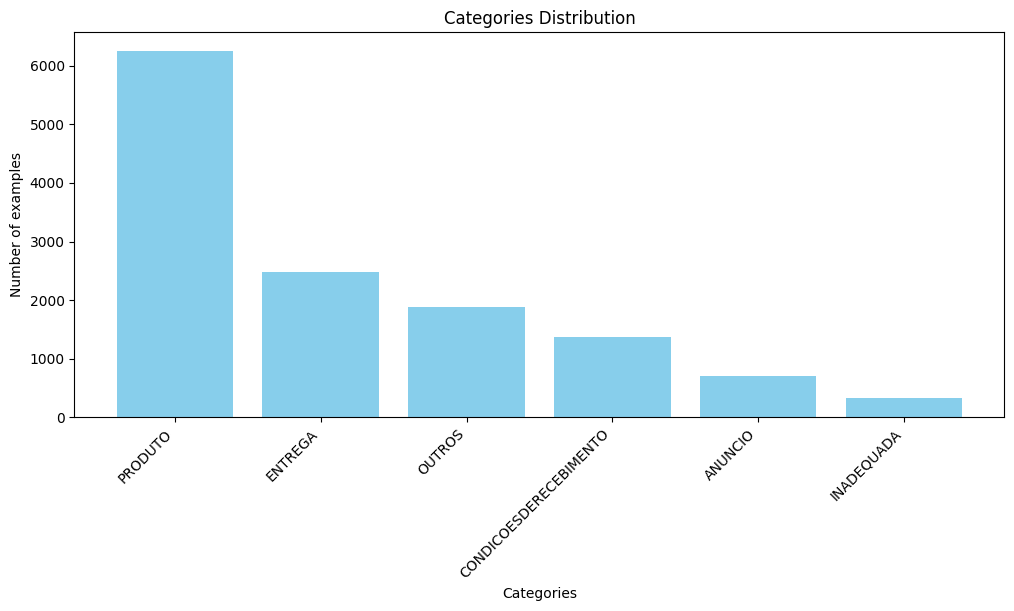

In [14]:
label_counts = train_data.iloc[:, 1:].sum()

# Ordenar por frequência
label_counts = dict(sorted(label_counts.items(), key=lambda item: item[1], reverse=True))

print(label_counts)

# Plotar gráfico
plt.figure(figsize=(12, 5))
plt.bar(label_counts.keys(), label_counts.values(), color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Categories")
plt.ylabel("Number of examples")
plt.title("Categories Distribution")
plt.show()

Number of labels per review distribution:
1    4188
2    2741
3     943
4     122
5       8
Name: count, dtype: int64


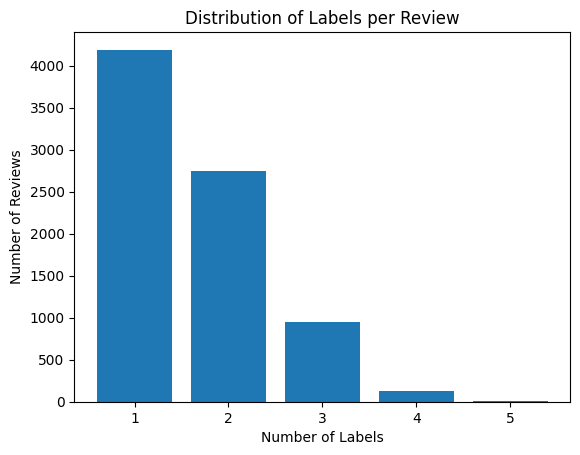

In [15]:
label_counts_per_review = train_data[label_cols].sum(axis=1)
print("Number of labels per review distribution:")
print(pd.Series(label_counts_per_review).value_counts())

plt.hist(label_counts_per_review, bins=range(1, 7), align='left', rwidth=0.8)
plt.title("Distribution of Labels per Review")
plt.xlabel("Number of Labels")
plt.ylabel("Number of Reviews")
plt.show()

* 4188 reviews have exactly 1 label
* 2741 reviews have exactly 2 labels
* 943 reviews have exactly 3 labels
* 122 reviews have exactly 4 labels
* 8 reviews have exactly 5 labels

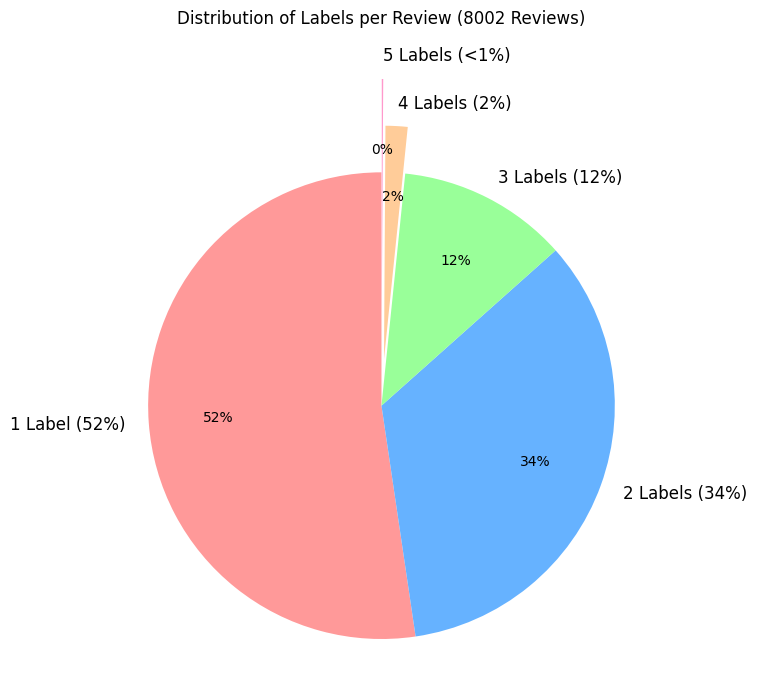

In [16]:
label_counts = label_counts_per_review.value_counts().values
total_reviews = 8002 # number of training examples
percentages = [count / total_reviews * 100 for count in label_counts]
labels = ['1 Label (52%)', '2 Labels (34%)', '3 Labels (12%)', '4 Labels (2%)', '5 Labels (<1%)']

# Create pie chart
plt.figure(figsize=(8, 8))
# Add explode to pull out small slices, and adjust label distance
explode = [0, 0, 0, 0.2, 0.4]  # Pull out 4 and 5 labels a bit
wedges, texts, autotexts = plt.pie(percentages, labels=labels, autopct='%1.0f%%', startangle=90,
                                   colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC'],
                                   explode=explode, labeldistance=1.1, pctdistance=0.7)

# Customize text for readability
for text in texts:
    text.set_fontsize(12)  # Bigger label text
for autotext in autotexts:
    autotext.set_fontsize(10)  # Bigger percentage text
    autotext.set_color('black')  # Black for contrast

plt.title("Distribution of Labels per Review (8002 Reviews)", pad=20)
plt.axis('equal')  # Keep it circular
plt.show()

In [17]:
text_lengths = [len(example["review_text"].split()) for example in dataset["train"]]

print(f"Average text length: {np.mean(text_lengths):.2f} words")
print(f"Maximum text length: {np.max(text_lengths)} words")
print(f"Minimum text length: {np.min(text_lengths)} words")

Average text length: 24.58 words
Maximum text length: 428 words
Minimum text length: 1 words


## **Preprocessing**

In [18]:
# Load the Portuguese language model
nlp = spacy.load('pt_core_news_lg')

# Initialize the Snowball Stemmer for Portuguese
stemmer = SnowballStemmer("portuguese")

def preprocess_text(text, method="lemma"):
    """
    Preprocess text by applying lemmatization or stemming.

    Parameters:
    - text (str): Input text
    - method (str): "lemma" for lemmatization, "stem" for stemming

    Returns:
    - str: Preprocessed text
    """
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenization and processing
    doc = nlp(text)

    if method == "lemma":
        tokens = [token.lemma_ for token in doc if not token.is_stop]
    elif method == "stem":
        tokens = [stemmer.stem(token.text) for token in doc if not token.is_stop]
    else:
        raise ValueError("Method must be 'lemma' or 'stem'")

    return ' '.join(tokens)

# Apply preprocessing with both methods to compare
train_data['lemmatized_reviews'] = train_data['review_text'].apply(lambda x: preprocess_text(x, method="lemma"))
train_data['stemmed_reviews'] = train_data['review_text'].apply(lambda x: preprocess_text(x, method="stem"))

val_data['lemmatized_reviews'] = val_data['review_text'].apply(lambda x: preprocess_text(x, method="lemma"))
val_data['stemmed_reviews'] = val_data['review_text'].apply(lambda x: preprocess_text(x, method="stem"))

test_data['lemmatized_reviews'] = test_data['review_text'].apply(lambda x: preprocess_text(x, method="lemma"))
test_data['stemmed_reviews'] = test_data['review_text'].apply(lambda x: preprocess_text(x, method="stem"))


In [19]:
print("Original:", train_data['review_text'].iloc[0])
print("Lemmatized:", train_data['lemmatized_reviews'].iloc[0])
print("Stemmed:", train_data['stemmed_reviews'].iloc[0])

Original: Aparelho muito bom, confiável e com valor aquisitivo em conta, ou seja: tudo que a massa precisa!
Lemmatized: aparelho confiável aquisitivo conta ser massa precisar
Stemmed: aparelh confiável aquisit cont sej mass precis


In [20]:
train_data.head()

,review_text,ENTREGA,OUTROS,PRODUTO,CONDICOESDERECEBIMENTO,INADEQUADA,ANUNCIO,lemmatized_reviews,stemmed_reviews
0,"Aparelho muito bom, confiável e com valor aqui...",0,0,1,0,0,0,aparelho confiável aquisitivo conta ser massa ...,aparelh confiável aquisit cont sej mass precis
1,"A história é muito boa, porém o autor ""enrolou...",0,0,1,0,0,0,história autor enrolar livro,histór autor enrol livr
2,"Entrega rápida, produto muito bom Amei. Pratic...",1,0,1,0,0,0,entregar rápido produto amar praticidade,entreg ráp produt ame pratic
3,Produto otimo so falta o carregador da maquina...,0,0,1,1,0,0,produto otimo so carregador maquina pequeno,produt otim so carreg maquin pequen
4,a proteção anti queda não é boa se cair de fr...,0,0,1,0,0,0,proteção anti queda cair frente tela,proteçã anti qued cair frent tel


Part Of Speech (POS) serves to identify nouns, verbs, etc., and filtered to keep only certain POS tags (e.g., nouns) before feature extraction. We didn't apply POS, because lemmatization already simplifies terms and multi-label needs flexible features (not just nouns or adjectives), so this technique might be redundant.

## **Feature Extraction**

## **1- TF-IDF**

### **1.1- Unigram TF-IDF Vectorization**

In [21]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit on the training data and transform it into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['lemmatized_reviews'])
# Transform the validation and test data using the same vectorizer
X_val_tfidf = tfidf_vectorizer.transform(val_data['lemmatized_reviews'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['lemmatized_reviews'])

# Check the shape of the TF-IDF features, these are sparse matrices containing the TF-IDF features for the training, validation, and test sets, respectively.
# each row is a document and each column is a word
"""print("Training data shape:", X_train_tfidf.shape)
print("Validation data shape:", X_val_tfidf.shape)
print("Test data shape:", X_test_tfidf.shape, end="\n\n")"""

# Sum the TF-IDF scores for each word across all documents
tfidf_scores = np.asarray(X_train_tfidf.sum(axis=0)).flatten()

# Get the feature names (words in the vocabulary)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a dictionary of words and their corresponding TF-IDF scores
word_tfidf_scores = dict(zip(feature_names, tfidf_scores))

# Sort the words by their TF-IDF scores in descending order
sorted_words = sorted(word_tfidf_scores.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 words
print("Top 20 unigrams by TF-IDF score:")
for word, score in sorted_words[:20]:
    print(f"{word}: {score:.4f}")

Top 20 unigrams by TF-IDF score:
produto: 488.2262
recomendar: 234.1057
chegar: 203.3263
comprar: 199.9689
prazo: 194.0114
qualidade: 185.3566
gostar: 182.2771
entregar: 181.8631
entrega: 173.2043
rápido: 154.2068
excelente: 151.3629
bom: 146.1159
dia: 143.8600
recebi: 136.4783
vir: 136.1746
super: 119.6697
ótimo: 114.8176
atender: 106.3468
compra: 105.3768
pra: 98.0093


### **1.2- Bigram TF-IDF Vectorization**

In [22]:
# Define the TF-IDF vectorizer with unigrams and bigrams
tfidf_bigram = TfidfVectorizer(ngram_range=(2, 2))  # Unigrams + bigrams

# Fit and transform the training data
X_train_tfidf_bi = tfidf_bigram.fit_transform(train_data['lemmatized_reviews'])
# Transform the validation and test data
X_val_tfidf_bi = tfidf_bigram.transform(val_data['lemmatized_reviews'])
X_test_tfidf_bi = tfidf_bigram.transform(test_data['lemmatized_reviews'])

# Calculate the sum of TF-IDF scores for each feature (word/phrase)
tfidf_scores_bi = np.asarray(X_train_tfidf_bi.sum(axis=0)).flatten()
# Get the feature names (words/phrases)
feature_names_bi = tfidf_bigram.get_feature_names_out()
# Create a dictionary of words/phrases and their corresponding TF-IDF scores
word_tfidf_scores_bi = dict(zip(feature_names_bi, tfidf_scores_bi))
# Sort the words/phrases by their TF-IDF scores in descending order
sorted_words_bi = sorted(word_tfidf_scores_bi.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 unigrams and bigrams by TF-IDF score
print("\nTop 20 bigrams by TF-IDF score:")
for word, score in sorted_words_bi[:20]:
    print(f"{word}: {score:.4f}")


Top 20 bigrams by TF-IDF score:
recebi produto: 55.4152
chegar prazo: 55.0975
produto chegar: 49.3651
gostar produto: 47.2966
entregar prazo: 47.2189
produto entregar: 41.0208
atender expectativa: 37.7258
ótimo qualidade: 37.1043
produto excelente: 34.6375
bom produto: 33.2058
produto qualidade: 32.6299
produto ótimo: 32.1825
excelente produto: 30.1993
entregar rápido: 29.5193
super recomendar: 29.4634
produto atender: 28.9780
produto vir: 28.8988
super rápido: 28.6211
valer pena: 28.4338
comprar produto: 27.4269


### **1.3- Unigram + Bigram TF-IDF Vectorization**

In [23]:
def create_tfidf_features_uni_bi(train_texts, val_texts, test_texts, min_df=1, max_features=None):
    """
    Generate TF-IDF features with specified min_df and max_features.
    
    Parameters:
    - train_texts: Training data (e.g., train_data['lemmatized_reviews'])
    - val_texts: Validation data (e.g., val_data['lemmatized_reviews'])
    - test_texts: Test data (e.g., test_data['lemmatized_reviews'])
    - min_df: Minimum document frequency (default=2)
    - max_features: Maximum number of features (default=None, no limit)
    
    Returns:
    - X_train_tfidf, X_val_tfidf, X_test_tfidf: TF-IDF matrices
    - feature_names: List of feature names
    """
    # Define TF-IDF vectorizer with unigrams and bigrams
    tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=min_df, max_features=max_features)
    
    # Fit and transform training data
    X_train_tfidf = tfidf.fit_transform(train_texts)
    # Transform validation and test data
    X_val_tfidf = tfidf.transform(val_texts)
    X_test_tfidf = tfidf.transform(test_texts)
    
    # Get feature names and scores
    feature_names = tfidf.get_feature_names_out()
    tfidf_scores = np.asarray(X_train_tfidf.sum(axis=0)).flatten()
    word_tfidf_scores = dict(zip(feature_names, tfidf_scores))
    sorted_words = sorted(word_tfidf_scores.items(), key=lambda x: x[1], reverse=True)
    
    
    print(f"Feature space size: {X_train_tfidf.shape[1]}")
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, feature_names, sorted_words[:20]

# Example usage (you can change parameters here)
X_train_tfidf_bi, X_val_tfidf_bi, X_test_tfidf_bi, feature_names_bi, sorted_words = create_tfidf_features_uni_bi(
    train_data['lemmatized_reviews'],
    val_data['lemmatized_reviews'],
    test_data['lemmatized_reviews'],
    min_df=1,  # Change this to 2, 3, etc.
    max_features=5000  # Change to 5000, 8000, or None
)

# Print top 20 terms
print(f"\nTop 20 unigrams + bigrams by TF-IDF score")
for word, score in sorted_words[:20]:
    print(f"{word}: {score:.4f}")

Feature space size: 5000

Top 20 unigrams + bigrams by TF-IDF score
produto: 397.9442
recomendar: 184.9531
comprar: 181.4826
chegar: 162.0091
gostar: 155.7969
qualidade: 146.8700
prazo: 144.8143
entregar: 140.2032
entrega: 133.6801
bom: 124.6411
dia: 122.2652
vir: 121.7276
excelente: 117.9173
rápido: 116.5107
recebi: 114.0214
super: 95.8461
pra: 91.9058
ficar: 89.7605
ótimo: 89.1564
atender: 87.7731


There's only single words in the top 20 TF-IDF scores for unigrams + bigrams, because the unigrams have higher TF-IDF scores compared to the bigrams. This can happen if the unigrams are more frequent or carry more weight in the dataset.

Why unigrams + bigrams? Unigrams capture individual word importance, while bigrams preserve some context (e.g., "não entregue" might indicate a delivery issue better than "não" or "entregue" alone). Since reviews are short (avg. 24.58 words), bigrams add value without overwhelming the feature space.

For word distribution, we choose TF-IDF with unigrams + bigrams (ngram_range=(1, 2), 5000 features) as it captures both dominant single words (e.g., "produto": 397.94) and contextual phrases (e.g., "chegar prazo") in the RePro dataset. This reflects the mix of 52% single-label and 48% multi-label reviews, providing a comprehensive view of key terms without relying on model performance.

In [24]:
label_names = ['ENTREGA', 'OUTROS', 'PRODUTO', 'CONDICOESDERECEBIMENTO', 'INADEQUADA', 'ANUNCIO']

y_train = train_data[label_names].to_numpy()
y_val = val_data[label_names].to_numpy()
y_test = test_data[label_names].to_numpy()
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (8002, 6)
y_val shape: (994, 6)
y_test shape: (1007, 6)


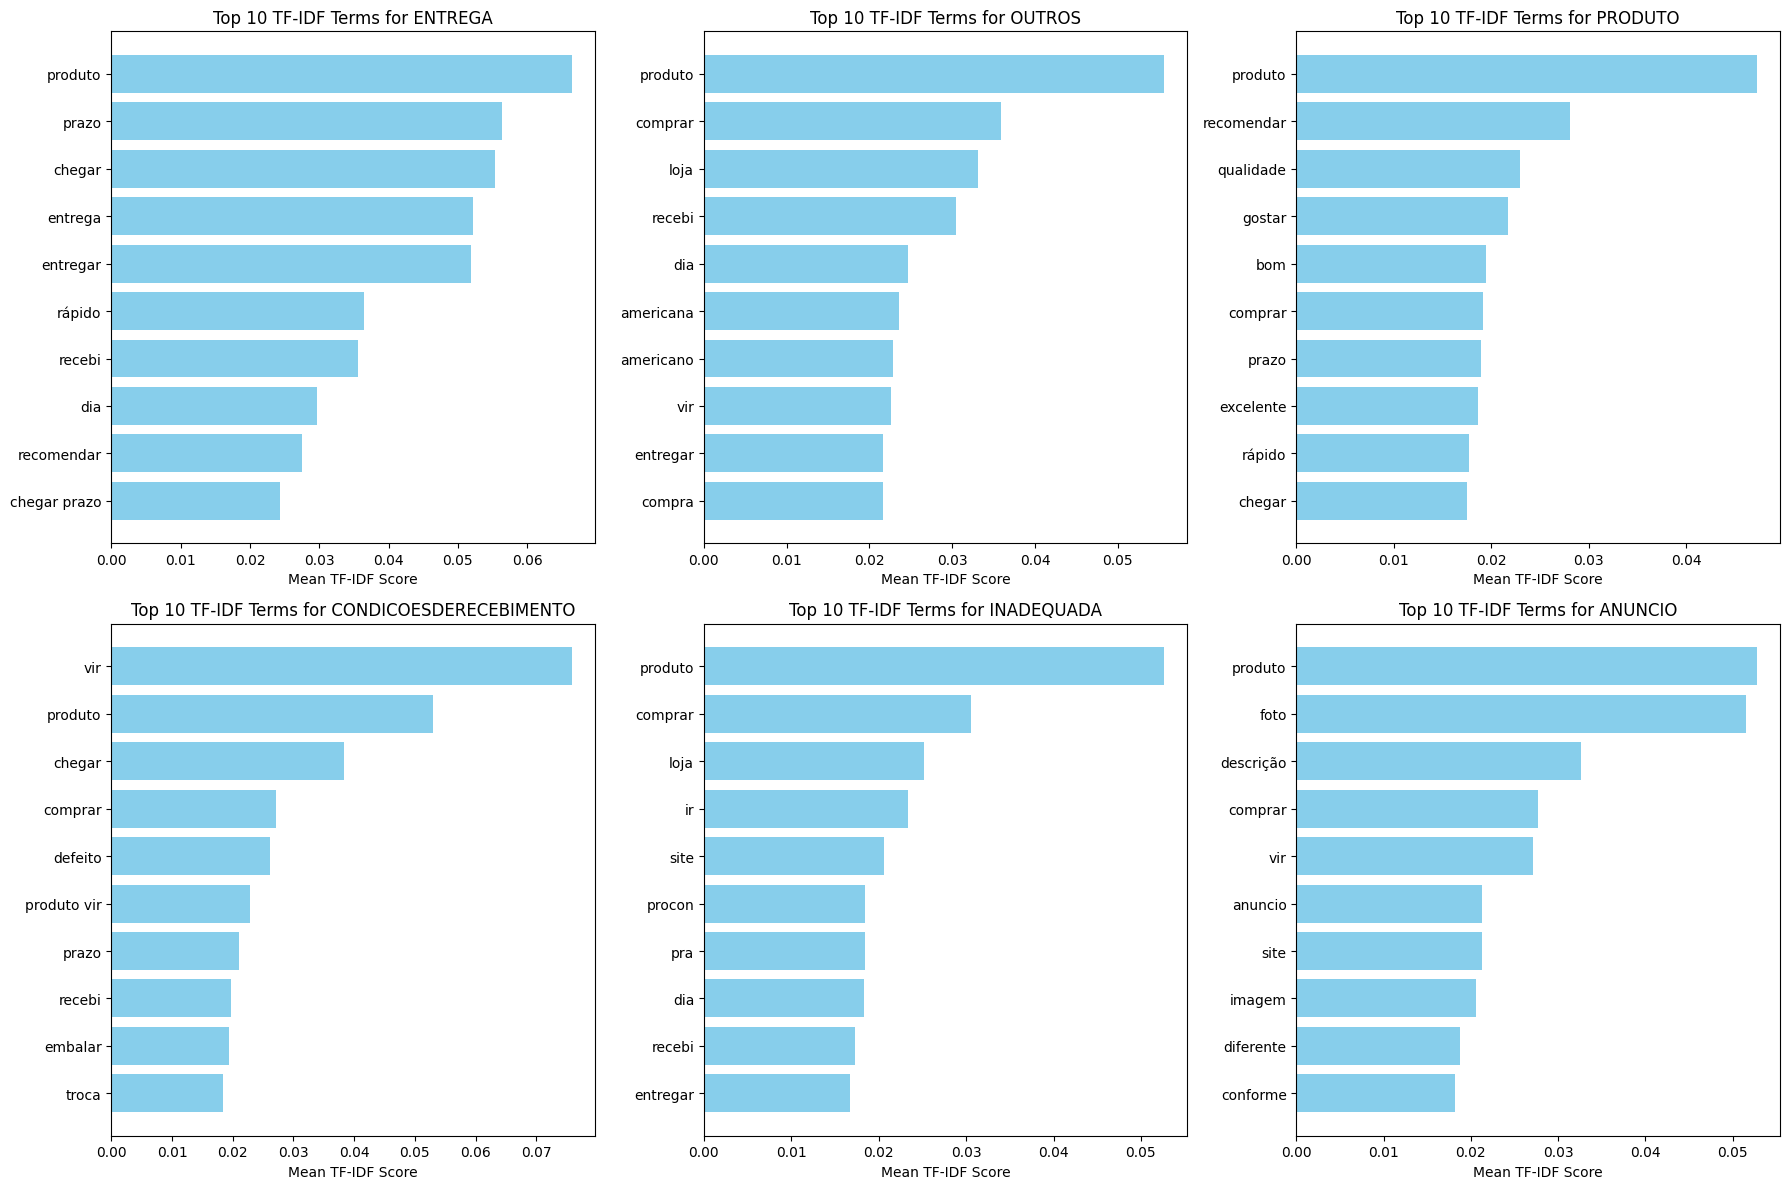

In [25]:
n_top = 10  # Number of top terms to show per label
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2x3 grid for 6 labels
axes = axes.flatten()

for i, label in enumerate(label_names):
    # Indices of reviews where this label is true (1)
    label_indices = np.where(y_train[:, i] == 1)[0]
    # Average TF-IDF scores for those reviews
    label_tfidf = X_train_tfidf_bi[label_indices].mean(axis=0).A1  # Convert sparse to 1D array
    # Get top N terms
    top_indices = np.argsort(label_tfidf)[-n_top:][::-1]  # Sort descending
    top_terms = feature_names_bi[top_indices]
    top_scores = label_tfidf[top_indices]

    # Step 5: Plot horizontal bar chart
    axes[i].barh(top_terms, top_scores, color='skyblue')
    axes[i].set_title(f'Top {n_top} TF-IDF Terms for {label}')
    axes[i].set_xlabel('Mean TF-IDF Score')
    axes[i].invert_yaxis()  # Highest score at top

# Adjust layout and display
plt.tight_layout()
plt.show()

### Feature Space

In [26]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1))  # Unigrams
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 9824


In [27]:
vectorizer = TfidfVectorizer(ngram_range=(2, 2))  # Unigrams + bigrams
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 59291


In [28]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # Unigrams and bigrams
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 69115


In [29]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)  # Unigrams and bigrams only keeping the terms that occur more than 2 times
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 11400


In [30]:
vectorizer = TfidfVectorizer(max_features=10000 ,ngram_range=(1, 2))  # Unigrams and bigrams with maximum number of features
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 10000


After applying TF-IDF vectorization with unigrams and bigrams our dataset, after preprocessing and vectorization, has generated a vocabulary of 69115 unique features (terms can be unigrams or bigrams).


min_df=2 -> 11400\
min_df=3 -> 6142


This is the dimensionality of our feature space—each review is represented as a sparse vector with 69115 possible positions, where most values are zero (since a single review uses only a tiny fraction of the vocabulary).

Our feature space is much larger than our sample size, this can lead to sparsity, where most feature values are zero, and potentially overfitting if not handled carefully. To address this high dimensionality and reduce noise from rare terms, we set min_df=2 in the TfidfVectorizer, excluding terms that appear in fewer than two reviews. This reduced the feature space to 11400 features, making it more manageable while retaining meaningful unigrams and bigrams. This adjustment helps mitigate sparsity and overfitting by focusing the model on terms with broader relevance across the dataset, balancing computational efficiency and classification performance

TF-IDF is sparse—each review is a vector of length equal to the feature space (e.g., 11,400), but most entries are zero. It’s frequency-based and doesn’t capture semantic relationships (e.g., "atraso" and "demora" are treated as unrelated unless they co-occur exactly).

**Benefits vs. TF-IDF**
* Feature Space Reduction:
TF-IDF: 69,115 → 11,400 → 10,000/5,000 (still sparse).
Word2Vec/Doc2Vec: 100 or 300 dims (dense). This slashes dimensionality by orders of magnitude, reducing sparsity and potentially overfitting—crucial with only 8002 samples.
* Semantic Understanding:
TF-IDF misses relationships (e.g., "defeito" and "estragado" are separate). Embeddings group similar terms, which could boost performance on short reviews (avg. 24.58 words) with varied phrasing.
* Imbalance Handling:
Your labels are imbalanced (PRODUTO: 6258, INADEQUADA: 328). Embeddings might help rare labels if synonyms or related terms (e.g., "falsificado," "inadequado") align in vector space.

**Risks**
* Data Size: 8002 reviews is modest for training embeddings from scratch. Pre-trained Word2Vec (e.g., Portuguese FastText) mitigates this, but Doc2Vec relies on your data alone.
* Complexity: Adds a step vs. TF-IDF, and averaging Word2Vec might dilute multi-label signals (e.g., ENTREGA + PRODUTO in one review).
* Performance: May not beat TF-IDF if your reviews are keyword-driven (e.g., "atraso" explicitly signals ENTREGA).

## **2- Word2Vec**

In [31]:
def tokenize(text):
    doc = nlp(text)
    return [token.text.lower() for token in doc if not token.is_stop and token.is_alpha]

train_tokens = [tokenize(text) for text in train_data["review_text"]]

# Treinar Word2Vec 
w2v_model = Word2Vec(sentences=train_tokens, vector_size=300, window=5, min_count=1, workers=4)

# Função para vetorizar uma revisão
def get_w2v_vector(text, model):
    tokens = tokenize(text)
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

# Aplicar a treino e validação
X_train_w2v = np.array([get_w2v_vector(text, w2v_model) for text in train_data["review_text"]])
X_val_w2v = np.array([get_w2v_vector(text, w2v_model) for text in val_data["review_text"]])

print("Word2Vec features:")
print("Training data:", X_train_w2v[:10])

Word2Vec features:
Training data: [[-0.14681411  0.24460901  0.0698402  ... -0.0860781   0.2234751
  -0.04822957]
 [-0.07032032  0.1176386   0.03267379 ... -0.03936501  0.10651825
  -0.02369997]
 [-0.14215773  0.33345976  0.07845306 ... -0.12017606  0.29324287
  -0.09480314]
 ...
 [-0.00128908 -0.00131401 -0.00294971 ... -0.00229093  0.00322753
  -0.00061842]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [32]:
print(X_train_tfidf_bi.shape)
print(X_train_w2v.shape)

(8002, 5000)
(8002, 300)


## **Combination of TF-IDF with Word2Vec**

In [33]:
def combine_tfidf_w2v(tfidf_matrix, w2v_matrix, method="concat"):
    """
    Combine TF-IDF and Word2Vec features.
    
    Parameters:
    - tfidf_matrix: TF-IDF feature matrix (sparse or dense)
    - w2v_matrix: Word2Vec feature matrix (dense)
    - method: "concat" for simple concatenation, "weighted" for TF-IDF-weighted Word2Vec
    
    Returns:
    - Combined feature matrix
    """
    if method == "concat":
        tfidf_matrix = tfidf_matrix.toarray()
        return np.hstack((tfidf_matrix, w2v_matrix))
    else:
        raise ValueError("Method must be 'concat' or 'weighted'")

X_train_combined = combine_tfidf_w2v(X_train_tfidf_bi, X_train_w2v, method="concat")
X_val_combined = combine_tfidf_w2v(X_val_tfidf_bi, X_val_w2v, method="concat")

print("Combined feature shape (train):", X_train_combined.shape)  # (8002, 5300) = 5000 TF-IDF + 300 W2V
print("Combined feature shape (val):", X_val_combined.shape)

Combined feature shape (train): (8002, 5300)
Combined feature shape (val): (994, 5300)


## **Models Training and Evaluation**

``One-vs-Rest (OvR)`` não é um classificador em si, mas uma estratégia para transformar classificadores binários (como Naive Bayes e Regressão Logística) em modelos que suportam multi-label ou multi-classe.

O ``Multinomial Naive Bayes (MultinomialNB)`` é um modelo estatístico ideal para classificação de texto porque:

✅ Lida bem com representações baseadas em frequência, como o TF-IDF.\
✅ É eficiente e rápido, pois calcula probabilidades de forma simples.\
✅ Funciona bem para problemas onde as palavras aparecem independentemente, como em reviews de produtos.


### Razão da Escolha das Métricas de Avaliação

Na classificação multi-label, onde cada amostra pode ter múltiplos rótulos e há desbalanceamento (e.g., PRODUTO: 782 vs. INADEQUADA: 42 no validation), usamos **Macro F1**, **Micro F1** e **Hamming Loss** para capturar diferentes aspectos do desempenho do modelo:

- **Macro F1**: Dá peso igual a cada rótulo, destacando o desempenho em rótulos raros, essencial para balanceamento.
- **Micro F1**: Avalia o desempenho global, agregando predições e refletindo a força em rótulos frequentes.
- **Hamming Loss**: Mede a fração de erros por rótulo, oferecendo uma visão granular da consistência.

Essas métricas juntas avaliam equilíbrio (Macro F1), desempenho geral (Micro F1) e erro médio (Hamming Loss)

In [34]:
# Function to train and evaluate the baseline classifier
def evaluate_baseline(X_train, X_val, y_train, y_val, label_names, config_name):
    baseline_clf = OneVsRestClassifier(MultinomialNB())
    baseline_clf.fit(X_train, y_train)
    y_pred = baseline_clf.predict(X_val)
    
    print(f"\n=== Baseline Results for {config_name} ===")
    print("Relatório de Classificação por Rótulo:")
    print(classification_report(y_val, y_pred, target_names=label_names))
    
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    micro_f1 = f1_score(y_val, y_pred, average='micro')
    hamming = hamming_loss(y_val, y_pred)
    
    print("\nMétricas Gerais:")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Micro F1: {micro_f1:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    return macro_f1, micro_f1, hamming

# Função para avaliar modelos 
def evaluate_model(X_train, X_val, y_train, y_val, model_name, classifier):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_val)
    
    print(f"\n=== {model_name} ===")
    print("Relatório de Classificação por Rótulo:")
    print(classification_report(y_val, y_pred, target_names=label_names))
    
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    micro_f1 = f1_score(y_val, y_pred, average='micro')
    hamming = hamming_loss(y_val, y_pred)
    
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Micro F1: {micro_f1:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    return macro_f1, micro_f1, hamming

### Baseline Classifier - Naive Bayes

* TF-IDF

In [35]:
# List of configurations to test
configs = [
    {'min_df': 1, 'max_features': None, 'name': 'nothing'},
    {'min_df': 2, 'max_features': None, 'name': 'min_df=2 -> features = 11400'},
    {'min_df': 3, 'max_features': None, 'name': 'min_df=3 -> features = 6142'},
    {'min_df': 1, 'max_features': 5000, 'name': 'max_features=5000'},
    {'min_df': 1, 'max_features': 7000, 'name': 'max_features=7000'}
]

# Dictionary to store results
results = {}

# Loop through configurations
for config in configs:
    min_df = config['min_df']
    max_features = config['max_features']
    config_name = config['name']
    print(f"\n\n=== Testing Configuration: {config_name} ===")
    
    # Generate TF-IDF features
    tfidf_result = create_tfidf_features_uni_bi(
        train_data['lemmatized_reviews'],
        val_data['lemmatized_reviews'],
        test_data['lemmatized_reviews'],
        min_df=min_df,
        max_features=max_features
    )
    
    # Unpack return values
    X_train_tfidf_bi, X_val_tfidf_bi, X_test_tfidf_bi, feature_names_bi, sorted_words = tfidf_result
    
    # Evaluate baseline classifier
    macro_f1, micro_f1, hamming = evaluate_baseline(
        X_train_tfidf_bi, X_val_tfidf_bi, y_train, y_val, label_names, config_name
    )
    
    # Store results
    results[config_name] = {'macro_f1': macro_f1, 'micro_f1': micro_f1, 'hamming_loss': hamming}

# Print summary of results
print("\n=== Summary of Baseline Results ===")
for config_name, metrics in results.items():
    print(f"{config_name}: Macro F1={metrics['macro_f1']:.4f}, Micro F1={metrics['micro_f1']:.4f}, Hamming Loss={metrics['hamming_loss']:.4f}")



=== Testing Configuration: nothing ===
Feature space size: 69115

=== Baseline Results for nothing ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.97      0.68      0.80       311
                OUTROS       0.95      0.17      0.29       235
               PRODUTO       0.82      1.00      0.90       782
CONDICOESDERECEBIMENTO       1.00      0.01      0.01       171
            INADEQUADA       0.00      0.00      0.00        42
               ANUNCIO       0.00      0.00      0.00        88

             micro avg       0.85      0.63      0.73      1629
             macro avg       0.62      0.31      0.33      1629
          weighted avg       0.82      0.63      0.63      1629
           samples avg       0.85      0.72      0.76      1629


Métricas Gerais:
Macro F1: 0.3336
Micro F1: 0.7264
Hamming Loss: 0.1306


=== Testing Configuration: min_df=2 -> features = 11400 ===
Feature space 

/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Feature space size: 6142

=== Baseline Results for min_df=3 -> features = 6142 ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.91      0.82      0.86       311
                OUTROS       0.84      0.52      0.64       235
               PRODUTO       0.89      0.98      0.94       782
CONDICOESDERECEBIMENTO       0.90      0.27      0.42       171
            INADEQUADA       0.00      0.00      0.00        42
               ANUNCIO       0.91      0.11      0.20        88

             micro avg       0.89      0.74      0.81      1629
             macro avg       0.74      0.45      0.51      1629
          weighted avg       0.87      0.74      0.76      1629
           samples avg       0.91      0.81      0.83      1629


Métricas Gerais:
Macro F1: 0.5108
Micro F1: 0.8081
Hamming Loss: 0.0959


=== Testing Configuration: max_features=5000 ===
Feature space size: 5000

=== Baseline Results 

/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Feature space size: 7000

=== Baseline Results for max_features=7000 ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.92      0.81      0.86       311
                OUTROS       0.87      0.52      0.65       235
               PRODUTO       0.89      0.99      0.93       782
CONDICOESDERECEBIMENTO       0.92      0.26      0.40       171
            INADEQUADA       0.00      0.00      0.00        42
               ANUNCIO       0.89      0.09      0.16        88

             micro avg       0.89      0.74      0.81      1629
             macro avg       0.75      0.44      0.50      1629
          weighted avg       0.87      0.74      0.76      1629
           samples avg       0.90      0.81      0.83      1629


Métricas Gerais:
Macro F1: 0.5020
Micro F1: 0.8059
Hamming Loss: 0.0967

=== Summary of Baseline Results ===
nothing: Macro F1=0.3336, Micro F1=0.7264, Hamming Loss=0.1306
min_df=2

/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


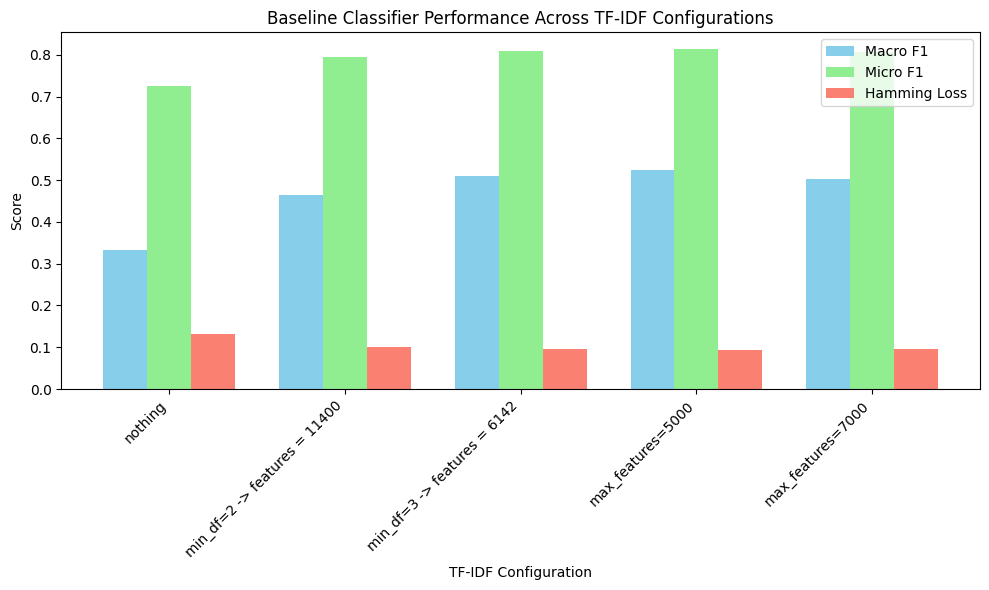

In [36]:
# Plotting the results
config_names = list(results.keys())
macro_f1_scores = [results[config]['macro_f1'] for config in config_names]
micro_f1_scores = [results[config]['micro_f1'] for config in config_names]
hamming_losses = [results[config]['hamming_loss'] for config in config_names]

# Set up the bar plot
x = range(len(config_names))
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([i - width for i in x], macro_f1_scores, width, label='Macro F1', color='skyblue')
ax.bar(x, micro_f1_scores, width, label='Micro F1', color='lightgreen')
ax.bar([i + width for i in x], hamming_losses, width, label='Hamming Loss', color='salmon')

# Customize the plot
ax.set_xlabel('TF-IDF Configuration')
ax.set_ylabel('Score')
ax.set_title('Baseline Classifier Performance Across TF-IDF Configurations')
ax.set_xticks(x)
ax.set_xticklabels(config_names, rotation=45, ha='right')
ax.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

* Word2Vec / Combination of TF-IDF with Word2Vec

O classificador Naive Bayes Multinomial (MultinomialNB) só aceita valores não negativos e os embeddings do Word2Vec contêm valores negativos, já que o Word2Vec não restringe os valores dos vetores a serem positivos. Assim, vamos ignorar o baseline classifier, Naive Bayes, para o Word2Vec e para a combinação.

### F1-Scores by Label

| Label                  | nothing | min_df=2 | min_df=3 | max_features=5000 | max_features=7000 |
|-----------------------|---------|----------|----------|-------------------|-------------------|
| ENTREGA (311)         | 0.80    | 0.87     | 0.86     | 0.86              | 0.86              |
| OUTROS (235)          | 0.29    | 0.61     | 0.64     | 0.65              | 0.65              |
| PRODUTO (782)         | 0.90    | 0.93     | 0.94     | 0.94              | 0.93              |
| CONDICOESDERECEBIMENTO (171) | 0.01    | 0.29     | 0.42     | 0.48              | 0.40              |
| INADEQUADA (42)       | 0.00    | 0.00     | 0.00     | 0.00              | 0.00              |
| ANUNCIO (88)          | 0.00    | 0.09     | 0.20     | 0.22              | 0.16              |

Testei o baseline Naive Bayes com One-vs-Rest em quatro configurações de feature space usando TF-IDF (unigrams e bigrams): `min_df=2` (11,400 features), `max_features=8000` (8,000 features), `max_features=5000` (5,000 features) e `min_df=3` (6,142 features). Os resultados mostram que reduzir o feature space melhora consistentemente as métricas gerais. 

### Other classifiers
##### 1. Fine-tuned Logistic Regression
* TF-IDF

In [37]:
C_values = [0.01, 0.1, 1.0, 10.0]
results = {}

for C in C_values:
    model_logreg = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_features=5000)),
        ('Logistic Regression', OneVsRestClassifier(LogisticRegression(
            C=C, max_iter=1000, random_state=42, class_weight='balanced')))
    ])
    
    # Usar evaluate_model para treinar e avaliar
    macro_f1, micro_f1, hamming = evaluate_model(
        train_data['lemmatized_reviews'],  # Texto bruto de treino
        val_data['lemmatized_reviews'],    # Texto bruto de validação
        y_train,
        y_val,
        f"Logistic Regression (Pipeline, C={C})",
        model_logreg
    )
    
    # Armazenar resultados
    results[C] = {'Macro F1': macro_f1, 'Micro F1': micro_f1, 'Hamming Loss': hamming}

# Find and print the best C based on Macro F1
best_C = max(results, key=lambda x: results[x]['Macro F1'])
print(f"\n=== Best C Value ===")
print(f"Best C: {best_C} with Macro F1={results[best_C]['Macro F1']:.4f}, "
      f"Micro F1={results[best_C]['Micro F1']:.4f}, Hamming Loss={results[best_C]['Hamming Loss']:.4f}")


=== Logistic Regression (Pipeline, C=0.01) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.91      0.85      0.88       311
                OUTROS       0.67      0.71      0.69       235
               PRODUTO       0.93      0.91      0.92       782
CONDICOESDERECEBIMENTO       0.69      0.71      0.70       171
            INADEQUADA       0.17      0.69      0.27        42
               ANUNCIO       0.74      0.82      0.78        88

             micro avg       0.78      0.84      0.81      1629
             macro avg       0.68      0.78      0.70      1629
          weighted avg       0.83      0.84      0.83      1629
           samples avg       0.83      0.87      0.83      1629

Macro F1: 0.7045
Micro F1: 0.8059
Hamming Loss: 0.1102

=== Logistic Regression (Pipeline, C=0.1) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support



/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Logistic Regression (Pipeline, C=1.0) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.90      0.94      0.92       311
                OUTROS       0.74      0.80      0.77       235
               PRODUTO       0.95      0.90      0.93       782
CONDICOESDERECEBIMENTO       0.75      0.80      0.77       171
            INADEQUADA       0.18      0.48      0.26        42
               ANUNCIO       0.81      0.84      0.83        88

             micro avg       0.83      0.87      0.85      1629
             macro avg       0.72      0.79      0.75      1629
          weighted avg       0.87      0.87      0.86      1629
           samples avg       0.87      0.90      0.86      1629

Macro F1: 0.7464
Micro F1: 0.8509
Hamming Loss: 0.0832


/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Logistic Regression (Pipeline, C=10.0) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.92      0.94      0.93       311
                OUTROS       0.76      0.79      0.77       235
               PRODUTO       0.94      0.91      0.93       782
CONDICOESDERECEBIMENTO       0.75      0.73      0.74       171
            INADEQUADA       0.19      0.33      0.24        42
               ANUNCIO       0.78      0.81      0.79        88

             micro avg       0.85      0.86      0.85      1629
             macro avg       0.72      0.75      0.73      1629
          weighted avg       0.86      0.86      0.86      1629
           samples avg       0.88      0.89      0.86      1629

Macro F1: 0.7335
Micro F1: 0.8543
Hamming Loss: 0.0801

=== Best C Value ===
Best C: 1.0 with Macro F1=0.7464, Micro F1=0.8509, Hamming Loss=0.0832


/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


* Word2Vec

In [38]:
# Logistic Regression com Word2Vec
C_values = [0.01, 0.1, 1.0, 10.0]
results_w2v_logreg = {}
for C in C_values:
    model_logreg_w2v = OneVsRestClassifier(LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced'))
    macro_f1, micro_f1, hamming = evaluate_model(X_train_w2v, X_val_w2v, y_train, y_val, 
                                                 f"Logistic Regression (Word2Vec, C={C})", model_logreg_w2v)
    results_w2v_logreg[C] = {'Macro F1': macro_f1, 'Micro F1': micro_f1, 'Hamming Loss': hamming}

best_C_w2v = max(results_w2v_logreg, key=lambda x: results_w2v_logreg[x]['Macro F1'])
print(f"\n=== Best C Value (Word2Vec) ===")
print(f"Best C: {best_C_w2v} with Macro F1={results_w2v_logreg[best_C_w2v]['Macro F1']:.4f}, "
      f"Micro F1={results_w2v_logreg[best_C_w2v]['Micro F1']:.4f}, Hamming Loss={results_w2v_logreg[best_C_w2v]['Hamming Loss']:.4f}")



=== Logistic Regression (Word2Vec, C=0.01) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.51      0.77      0.61       311
                OUTROS       0.41      0.68      0.51       235
               PRODUTO       0.93      0.76      0.83       782
CONDICOESDERECEBIMENTO       0.23      0.57      0.33       171
            INADEQUADA       0.04      0.31      0.08        42
               ANUNCIO       0.12      0.57      0.20        88

             micro avg       0.44      0.71      0.54      1629
             macro avg       0.37      0.61      0.43      1629
          weighted avg       0.63      0.71      0.64      1629
           samples avg       0.48      0.73      0.54      1629

Macro F1: 0.4273
Micro F1: 0.5425
Hamming Loss: 0.3255

=== Logistic Regression (Word2Vec, C=0.1) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support



* Combination

In [39]:
# Logistic Regression com Combinação
results_combined_logreg = {}
for C in C_values:
    model_logreg_combined = OneVsRestClassifier(LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced'))
    macro_f1, micro_f1, hamming = evaluate_model(X_train_combined, X_val_combined, y_train, y_val, 
                                                 f"Logistic Regression (TF-IDF + Word2Vec, C={C})", model_logreg_combined)
    results_combined_logreg[C] = {'Macro F1': macro_f1, 'Micro F1': micro_f1, 'Hamming Loss': hamming}

best_C_combined = max(results_combined_logreg, key=lambda x: results_combined_logreg[x]['Macro F1'])
print(f"\n=== Best C Value (TF-IDF + Word2Vec) ===")
print(f"Best C: {best_C_combined} with Macro F1={results_combined_logreg[best_C_combined]['Macro F1']:.4f}, "
      f"Micro F1={results_combined_logreg[best_C_combined]['Micro F1']:.4f}, Hamming Loss={results_combined_logreg[best_C_combined]['Hamming Loss']:.4f}")



=== Logistic Regression (TF-IDF + Word2Vec, C=0.01) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.57      0.82      0.67       311
                OUTROS       0.54      0.71      0.61       235
               PRODUTO       0.93      0.86      0.90       782
CONDICOESDERECEBIMENTO       0.45      0.71      0.55       171
            INADEQUADA       0.07      0.40      0.12        42
               ANUNCIO       0.21      0.74      0.33        88

             micro avg       0.57      0.80      0.66      1629
             macro avg       0.46      0.71      0.53      1629
          weighted avg       0.70      0.80      0.73      1629
           samples avg       0.62      0.82      0.67      1629

Macro F1: 0.5303
Micro F1: 0.6614
Hamming Loss: 0.2230


/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Logistic Regression (TF-IDF + Word2Vec, C=0.1) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.82      0.87      0.85       311
                OUTROS       0.64      0.76      0.70       235
               PRODUTO       0.95      0.89      0.92       782
CONDICOESDERECEBIMENTO       0.62      0.78      0.69       171
            INADEQUADA       0.17      0.57      0.26        42
               ANUNCIO       0.63      0.81      0.71        88

             micro avg       0.76      0.84      0.80      1629
             macro avg       0.64      0.78      0.69      1629
          weighted avg       0.81      0.84      0.82      1629
           samples avg       0.80      0.87      0.81      1629

Macro F1: 0.6878
Micro F1: 0.7992
Hamming Loss: 0.1157


/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Logistic Regression (TF-IDF + Word2Vec, C=1.0) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.90      0.93      0.92       311
                OUTROS       0.71      0.80      0.76       235
               PRODUTO       0.95      0.91      0.93       782
CONDICOESDERECEBIMENTO       0.74      0.80      0.76       171
            INADEQUADA       0.24      0.52      0.33        42
               ANUNCIO       0.80      0.84      0.82        88

             micro avg       0.83      0.87      0.85      1629
             macro avg       0.72      0.80      0.75      1629
          weighted avg       0.86      0.87      0.86      1629
           samples avg       0.87      0.90      0.87      1629

Macro F1: 0.7524
Micro F1: 0.8529
Hamming Loss: 0.0822


/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Logistic Regression (TF-IDF + Word2Vec, C=10.0) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.92      0.94      0.93       311
                OUTROS       0.75      0.80      0.77       235
               PRODUTO       0.94      0.91      0.93       782
CONDICOESDERECEBIMENTO       0.74      0.73      0.73       171
            INADEQUADA       0.23      0.33      0.27        42
               ANUNCIO       0.76      0.81      0.78        88

             micro avg       0.85      0.86      0.86      1629
             macro avg       0.72      0.75      0.74      1629
          weighted avg       0.86      0.86      0.86      1629
           samples avg       0.88      0.89      0.87      1629

Macro F1: 0.7359
Micro F1: 0.8559
Hamming Loss: 0.0791

=== Best C Value (TF-IDF + Word2Vec) ===
Best C: 1.0 with Macro F1=0.7524, Micro F1=0.8529, Hamming Loss=0.0822


/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### 2. Linear Support Vector Classification (SVC)

* TF-IDF

In [40]:
model_svc = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_features=5000)),
    ('Linear SVM', OneVsRestClassifier(LinearSVC(max_iter=1000, random_state=42, class_weight='balanced')))
])

# Usar evaluate_model para treinar e avaliar
macro_f1, micro_f1, hamming = evaluate_model(
    train_data['lemmatized_reviews'],  # Texto bruto de treino
    val_data['lemmatized_reviews'],    # Texto bruto de validação
    y_train,
    y_val,
    "SVM (Pipeline)",
    model_svc
)


=== SVM (Pipeline) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.91      0.95      0.93       311
                OUTROS       0.74      0.77      0.76       235
               PRODUTO       0.94      0.91      0.93       782
CONDICOESDERECEBIMENTO       0.73      0.72      0.72       171
            INADEQUADA       0.19      0.33      0.24        42
               ANUNCIO       0.76      0.78      0.77        88

             micro avg       0.84      0.86      0.85      1629
             macro avg       0.71      0.75      0.72      1629
          weighted avg       0.86      0.86      0.86      1629
           samples avg       0.87      0.89      0.86      1629

Macro F1: 0.7248
Micro F1: 0.8485
Hamming Loss: 0.0835


/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


* Word2Vec

In [41]:
# SVC com Word2Vec
model_svc_w2v = OneVsRestClassifier(LinearSVC(max_iter=1000, random_state=42, class_weight='balanced'))
evaluate_model(X_train_w2v, X_val_w2v, y_train, y_val, "SVM (Word2Vec)", model_svc_w2v)


=== SVM (Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.78      0.82      0.80       311
                OUTROS       0.54      0.74      0.62       235
               PRODUTO       0.94      0.83      0.88       782
CONDICOESDERECEBIMENTO       0.39      0.76      0.52       171
            INADEQUADA       0.09      0.55      0.15        42
               ANUNCIO       0.15      0.78      0.25        88

             micro avg       0.54      0.80      0.64      1629
             macro avg       0.48      0.75      0.54      1629
          weighted avg       0.73      0.80      0.74      1629
           samples avg       0.61      0.82      0.67      1629

Macro F1: 0.5363
Micro F1: 0.6441
Hamming Loss: 0.2411


(0.5363040878686804, 0.6440594059405941, 0.24111334674714957)

* Combination

In [42]:
# SVC com Combinação
model_svc_combined = OneVsRestClassifier(LinearSVC(max_iter=1000, random_state=42, class_weight='balanced'))
evaluate_model(X_train_combined, X_val_combined, y_train, y_val, "SVM (TF-IDF + Word2Vec)", model_svc_combined)


=== SVM (TF-IDF + Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.91      0.95      0.93       311
                OUTROS       0.74      0.78      0.76       235
               PRODUTO       0.94      0.92      0.93       782
CONDICOESDERECEBIMENTO       0.73      0.73      0.73       171
            INADEQUADA       0.25      0.33      0.28        42
               ANUNCIO       0.75      0.80      0.77        88

             micro avg       0.85      0.86      0.85      1629
             macro avg       0.72      0.75      0.73      1629
          weighted avg       0.86      0.86      0.86      1629
           samples avg       0.88      0.89      0.86      1629

Macro F1: 0.7329
Micro F1: 0.8541
Hamming Loss: 0.0803


/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.7328821224281058, 0.8540968626256473, 0.08031522468142187)

##### 3. XGBoost

In [43]:
def compute_scale_pos_weight(y_train):
    n_samples, n_classes = y_train.shape
    scale_pos_weights = []
    for i in range(n_classes):
        pos_count = np.sum(y_train[:, i])
        neg_count = n_samples - pos_count
        if pos_count > 0:  # Avoid division by zero
            scale_pos_weights.append(neg_count / pos_count)
        else:
            scale_pos_weights.append(1.0)  # Default if no positive samples
    return scale_pos_weights

* TF-IDF

In [44]:
scale_pos_weights = compute_scale_pos_weight(y_train)

# Define the XGBoost pipeline
model_xgb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_features=5000)),
    ('XGBoost', OneVsRestClassifier(XGBClassifier(
        n_estimators=100,          
        max_depth=6,             
        learning_rate=0.1,       
        random_state=42,         
        scale_pos_weight=scale_pos_weights[0],  # Use first label’s weight as a simplification*
        eval_metric='logloss'    
    )))
])

# Usar evaluate_model para treinar e avaliar
macro_f1, micro_f1, hamming = evaluate_model(
    train_data['lemmatized_reviews'],  # Texto bruto de treino
    val_data['lemmatized_reviews'],    # Texto bruto de validação
    y_train,
    y_val,
    "XGBoost (Pipeline)",
    model_xgb
)


=== XGBoost (Pipeline) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.88      0.93      0.91       311
                OUTROS       0.78      0.69      0.73       235
               PRODUTO       0.85      0.99      0.91       782
CONDICOESDERECEBIMENTO       0.83      0.68      0.75       171
            INADEQUADA       1.00      0.12      0.21        42
               ANUNCIO       0.91      0.73      0.81        88

             micro avg       0.85      0.86      0.86      1629
             macro avg       0.88      0.69      0.72      1629
          weighted avg       0.85      0.86      0.84      1629
           samples avg       0.88      0.89      0.87      1629

Macro F1: 0.7193
Micro F1: 0.8552
Hamming Loss: 0.0798


/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


* Word2Vec

In [45]:
scale_pos_weights = compute_scale_pos_weight(y_train)

model_xgb_w2v = OneVsRestClassifier(XGBClassifier(
    n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42,
    scale_pos_weight=scale_pos_weights[0], eval_metric='logloss'
))

evaluate_model(X_train_w2v, X_val_w2v, y_train, y_val, "XGBoost (Word2Vec)", model_xgb_w2v)


=== XGBoost (Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.82      0.85      0.83       311
                OUTROS       0.63      0.66      0.65       235
               PRODUTO       0.86      0.98      0.92       782
CONDICOESDERECEBIMENTO       0.55      0.48      0.51       171
            INADEQUADA       0.50      0.10      0.16        42
               ANUNCIO       0.67      0.11      0.19        88

             micro avg       0.78      0.79      0.79      1629
             macro avg       0.67      0.53      0.54      1629
          weighted avg       0.77      0.79      0.76      1629
           samples avg       0.84      0.84      0.81      1629

Macro F1: 0.5438
Micro F1: 0.7868
Hamming Loss: 0.1169


(0.5437513484358144, 0.7867849495258489, 0.11686787391012743)

* Combination

In [46]:
# XGBoost com Combinação
model_xgb_combined = OneVsRestClassifier(XGBClassifier(
    n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42,
    scale_pos_weight=scale_pos_weights[0], eval_metric='logloss'
))
evaluate_model(X_train_combined, X_val_combined, y_train, y_val, "XGBoost (TF-IDF + Word2Vec)", model_xgb_combined)


=== XGBoost (TF-IDF + Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.89      0.93      0.91       311
                OUTROS       0.75      0.74      0.74       235
               PRODUTO       0.89      0.99      0.93       782
CONDICOESDERECEBIMENTO       0.77      0.65      0.71       171
            INADEQUADA       0.80      0.19      0.31        42
               ANUNCIO       0.92      0.77      0.84        88

             micro avg       0.86      0.87      0.86      1629
             macro avg       0.83      0.71      0.74      1629
          weighted avg       0.85      0.87      0.86      1629
           samples avg       0.89      0.90      0.88      1629

Macro F1: 0.7396
Micro F1: 0.8649
Hamming Loss: 0.0744


/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.739625162860083, 0.8648813146682898, 0.0744466800804829)

#### Comparison Table

| Model         | Feature Set   | Macro F1 | Micro F1 | Hamming Loss |
|---------------|---------------|----------|----------|--------------|
| Logistic Reg. | TF-IDF        | 0.7464   | 0.8509   | 0.0832       |
| Logistic Reg. | Word2Vec      | 0.5344   | 0.6476   | 0.2381       |
| **Logistic Reg.** | **Combination**   | **0.7536**   | **0.8522**   | **0.0825**       |
| SVC           | TF-IDF        | 0.7248   | 0.8485   | 0.0835       |
| SVC           | Word2Vec      | 0.5379   | 0.6504   | 0.2349       |
| **SVC**           | **Combination**   | **0.7389**   | **0.8555**   | **0.0795**       |
| **XGBoost**        | **TF-IDF**        | **0.7193**   | **0.8552**   | **0.0798**      |
| XGBoost       | Word2Vec      | 0.5072   | 0.7749   | 0.1222       |
| XGBoost       | Combination   | 0.7287   | 0.8546   | 0.0807       |

The Combination of TF-IDF and Word2Vec is generally the best choice for most models, as it leverages the strengths of both feature sets. For the XGBoost classifier, we decided to choose with TF-IDF even though does not achieve the highest Macro F1, it performs well in Micro F1 and Hamming Loss, making it a good candidate for comparison.

## **Testing**

In [47]:
X_train_tfidf, X_val_tfidf, X_test_tfidf_bi, _, _ = create_tfidf_features_uni_bi(
    train_data['lemmatized_reviews'],
    val_data['lemmatized_reviews'],
    test_data['lemmatized_reviews'],
    min_df=1,
    max_features=5000
)
print("Shape do TF-IDF (train):", X_train_tfidf.shape)
print("Shape do TF-IDF (val):", X_val_tfidf.shape)
print("Shape do TF-IDF (test):", X_test_tfidf_bi.shape)

Feature space size: 5000
Shape do TF-IDF (train): (8002, 5000)
Shape do TF-IDF (val): (994, 5000)
Shape do TF-IDF (test): (1007, 5000)


In [55]:
from scipy.sparse import vstack

# Combine training and validation sets
X_train_full_tfidf = vstack((X_train_tfidf, X_val_tfidf))

print(X_train_tfidf.shape, X_val_tfidf.shape)
print(X_train_full_tfidf.shape)

y_train_full = np.vstack((y_train, y_val))

X_train_full_combined = np.vstack((X_train_combined, X_val_combined))

(8002, 5000) (994, 5000)
(8996, 5000)


In [56]:
# Step 2: Generate Word2Vec features for the test set
X_test_w2v = np.array([get_w2v_vector(text, w2v_model) for text in test_data['lemmatized_reviews']])

In [57]:
# Step 3: Combine TF-IDF and Word2Vec features for the test set
X_test_combined = combine_tfidf_w2v(X_test_tfidf_bi, X_test_w2v, method="concat")

# Print the shape of the combined test features
print("Combined feature shape (test):", X_test_combined.shape)

Combined feature shape (test): (1007, 5300)


### Logistic Regression with Combined TF-IDF + Word2Vec

In [58]:
model_logreg_combined = OneVsRestClassifier(LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced', random_state=42))
print("\n=== Test Set ===")
evaluate_model(X_train_full_combined, X_test_combined, y_train_full, y_test, 
               "Logistic Regression (Combined TF-IDF + Word2Vec)", model_logreg_combined)


=== Test Set ===

=== Logistic Regression (Combined TF-IDF + Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.92      0.89      0.91       311
                OUTROS       0.70      0.82      0.76       236
               PRODUTO       0.96      0.88      0.92       782
CONDICOESDERECEBIMENTO       0.69      0.85      0.76       171
            INADEQUADA       0.15      0.46      0.22        41
               ANUNCIO       0.63      0.80      0.71        87

             micro avg       0.80      0.86      0.83      1628
             macro avg       0.67      0.79      0.71      1628
          weighted avg       0.85      0.86      0.85      1628
           samples avg       0.84      0.88      0.83      1628

Macro F1: 0.7117
Micro F1: 0.8255
Hamming Loss: 0.0975


/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.7116669204740855, 0.8254814814814815, 0.09748427672955975)

### SVM

In [59]:
model_svc = Pipeline([
    ('Linear SVM', OneVsRestClassifier(LinearSVC(max_iter=1000, random_state=42, class_weight='balanced')))
])

# Usar evaluate_model para treinar e avaliar
macro_f1, micro_f1, hamming = evaluate_model(
    X_train_full_combined,  # Texto bruto de treino
    X_test_combined,    # Texto bruto de validação
    y_train_full,
    y_test,
    "SVM (Pipeline-Combined TF-IDF + Word2Vec)",
    model_svc
)


=== SVM (Pipeline-Combined TF-IDF + Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.93      0.91      0.92       311
                OUTROS       0.73      0.79      0.76       236
               PRODUTO       0.96      0.89      0.92       782
CONDICOESDERECEBIMENTO       0.71      0.81      0.76       171
            INADEQUADA       0.11      0.24      0.15        41
               ANUNCIO       0.72      0.77      0.74        87

             micro avg       0.83      0.85      0.84      1628
             macro avg       0.69      0.74      0.71      1628
          weighted avg       0.86      0.85      0.85      1628
           samples avg       0.86      0.88      0.85      1628

Macro F1: 0.7097
Micro F1: 0.8397
Hamming Loss: 0.0874


/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [62]:
scale_pos_weights = compute_scale_pos_weight(y_train_full)

# Train and evaluate XGBoost with precomputed TF-IDF features
model_xgb_tfidf = OneVsRestClassifier(XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=scale_pos_weights[0],  # Use first label’s weight as a simplification
    eval_metric='logloss'
))

# Evaluate the model on the test set
evaluate_model(
    X_train_full_tfidf,  
    X_test_tfidf_bi,     
    y_train_full,
    y_test,
    "XGBoost (TF-IDF)",
    model_xgb_tfidf
)


=== XGBoost (TF-IDF) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.88      0.94      0.91       311
                OUTROS       0.78      0.67      0.72       236
               PRODUTO       0.85      0.99      0.92       782
CONDICOESDERECEBIMENTO       0.85      0.72      0.78       171
            INADEQUADA       0.50      0.07      0.13        41
               ANUNCIO       0.88      0.76      0.81        87

             micro avg       0.85      0.87      0.86      1628
             macro avg       0.79      0.69      0.71      1628
          weighted avg       0.84      0.87      0.85      1628
           samples avg       0.88      0.90      0.87      1628

Macro F1: 0.7115
Micro F1: 0.8593
Hamming Loss: 0.0770


/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.7114917416094183, 0.859304084720121, 0.07696127110228401)

## **Error Analysis**
For your best model (highest macro-F1, say), analyze misclassifications:

* False Positives/Negatives: Look at reviews where the model predicted a label incorrectly. Are short reviews (e.g., 1 word) harder to classify? Are rare labels (INADEQUADA) often missed due to imbalance?
* Feature Importance: For Logistic Regression, check the top TF-IDF features per label (highest coefficients). Do they make sense (e.g., "atraso" for ENTREGA)?
* Confusion: Since it’s multi-label, examine label co-occurrence (e.g., PRODUTO + ENTREGA misclassified as just PRODUTO).

In [ ]:
# Function to print confusion matrices for each label
def print_confusion_matrices(y_true, y_pred, model_name):
    print(f"\n=== Confusion Matrices for {model_name} ===")
    for i, label in enumerate(label_names):
        # Extract true and predicted values for this label
        y_true_label = y_true[:, i]
        y_pred_label = y_pred[:, i]
        
        # Compute confusion matrix
        cm = confusion_matrix(y_true_label, y_pred_label)
        
        # Extract TP, FP, FN, TN
        tn, fp, fn, tp = cm.ravel()
        
        print(f"\nLabel: {label}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"True Positives (TP): {tp}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")
        print(f"True Negatives (TN): {tn}")

# Print confusion matrices for both models
print_confusion_matrices(y_val, y_pred_logreg, "Logistic Regression (C=1.0)")
print_confusion_matrices(y_val, y_pred_xgb, "XGBoost")

NameError: name 'y_pred_logreg' is not defined

### Confusion Matrix Comparison Table

| Label                  | Model               | TP  | FP  | FN  | TN  |
|-----------------------|---------------------|-----|-----|-----|-----|
| **ENTREGA (311)**     | Logistic Regression | 293 | 27  | 18  | 656 |
|                       | XGBoost             | 289 | 38  | 22  | 645 |
| **OUTROS (235)**      | Logistic Regression | 185 | 60  | 50  | 699 |
|                       | XGBoost             | 161 | 45  | 74  | 714 |
| **PRODUTO (782)**     | Logistic Regression | 714 | 42  | 68  | 170 |
|                       | XGBoost             | 771 | 140 | 11  | 72  |
| **CONDICOESDERECEBIMENTO (171)** | Logistic Regression | 124 | 41  | 47  | 782 |
|                       | XGBoost             | 116 | 24  | 55  | 799 |
| **INADEQUADA (42)**   | Logistic Regression | 14  | 60  | 28  | 892 |
|                       | XGBoost             | 5   | 0   | 37  | 952 |
| **ANUNCIO (88)**      | Logistic Regression | 71  | 20  | 17  | 886 |
|                       | XGBoost             | 64  | 6   | 24  | 900 |


#### ENTREGA (Support: 311, Frequent)
- **Logistic Regression**:
  - **Recall**: 293/311 ≈ 0.94, **Precision**: 293/320 ≈ 0.92, **F1**: 0.92
  - **FN (18)**: Misses 18 instances—likely subtle delivery-related reviews lacking strong TF-IDF signals.
  - **FP (27)**: Overpredicts 27 times—possible overlap with PRODUTO (delivery often tied to products).
- **XGBoost**:
  - **Recall**: 289/311 ≈ 0.93, **Precision**: 289/327 ≈ 0.88, **F1**: 0.91
  - **FN (22)**: Slightly more misses—may underfit rare delivery patterns.
  - **FP (38)**: Higher overprediction—tree-based model might overfit to frequent delivery terms.

**Insight**: Logistic Regression balances precision and recall better (F1: 0.92 vs. 0.91). XGBoost’s higher FP suggests sensitivity to noisy features, reducing precision.


#### OUTROS (Support: 235, Moderate)
- **Logistic Regression**:
  - **Recall**: 185/235 ≈ 0.79, **Precision**: 185/245 ≈ 0.76, **F1**: 0.77
  - **FN (50)**: Misses 50 instances—OUTROS’ catch-all nature may lack distinct features.
  - **FP (60)**: Overpredicts 60 times—overlap with ANUNCIO or PRODUTO likely.
- **XGBoost**:
  - **Recall**: 161/235 ≈ 0.69, **Precision**: 161/206 ≈ 0.78, **F1**: 0.73
  - **FN (74)**: More misses—XGBoost struggles to detect OUTROS, possibly due to `scale_pos_weight` favoring frequent labels.
  - **FP (45)**: Fewer overpredictions—better precision.

**Insight**: Logistic Regression outperforms (F1: 0.77 vs. 0.73) with higher recall. OUTROS’ ambiguity challenges both, but XGBoost’s lower recall hurts its Macro F1.


#### PRODUTO (Support: 782, Dominant)
- **Logistic Regression**:
  - **Recall**: 714/782 ≈ 0.91, **Precision**: 714/756 ≈ 0.94, **F1**: 0.93
  - **FN (68)**: Misses 68 instances—subtle product mentions may lack strong features.
  - **FP (42)**: Moderate overprediction—overlap with ENTREGA or CONDICOESDERECEBIMENTO.
- **XGBoost**:
  - **Recall**: 771/782 ≈ 0.99, **Precision**: 771/911 ≈ 0.85, **F1**: 0.91
  - **FN (11)**: Near-perfect recall—excels at detecting PRODUTO.
  - **FP (140)**: High overprediction—overfits to frequent terms, misclassifying negatives.

**Insight**: XGBoost’s high recall boosts Micro F1 (0.8552), but lower precision (F1: 0.91 vs. 0.93) shows overprediction. Logistic Regression balances better for this dominant label.


#### CONDICOESDERECEBIMENTO (Support: 171, Moderate)
- **Logistic Regression**:
  - **Recall**: 124/171 ≈ 0.73, **Precision**: 124/165 ≈ 0.75, **F1**: 0.77
  - **FN (47)**: Misses 47 instances—subtle condition mentions may lack distinct features.
  - **FP (41)**: Overpredicts 41 times—overlap with ENTREGA or PRODUTO.
- **XGBoost**:
  - **Recall**: 116/171 ≈ 0.68, **Precision**: 116/140 ≈ 0.83, **F1**: 0.75
  - **FN (55)**: More misses—underpredicts this label.
  - **FP (24)**: Fewer overpredictions—higher precision.

**Insight**: Logistic Regression wins (F1: 0.77 vs. 0.75) with better recall. XGBoost’s precision gain doesn’t offset recall loss, suggesting underfitting.


#### INADEQUADA (Support: 42, Rare)
- **Logistic Regression**:
  - **Recall**: 14/42 ≈ 0.33, **Precision**: 14/74 ≈ 0.19, **F1**: 0.26
  - **FN (28)**: Misses 28 of 42—low support and feature overlap with OUTROS or ANUNCIO.
  - **FP (60)**: High overprediction—model overgeneralizes rare negative sentiment.
- **XGBoost**:
  - **Recall**: 5/42 ≈ 0.12, **Precision**: 5/5 = 1.00, **F1**: 0.21
  - **FN (37)**: Misses nearly all instances—severely underpredicts due to rarity.
  - **FP (0)**: Perfect precision—no overprediction, but at the cost of recall.

**Insight**: Logistic Regression performs better (F1: 0.26 vs. 0.21) due to higher recall, though both struggle. XGBoost’s conservative approach (zero FP) sacrifices detection of this rare label.


#### ANUNCIO (Support: 88, Rare)
- **Logistic Regression**:
  - **Recall**: 71/88 ≈ 0.81, **Precision**: 71/91 ≈ 0.78, **F1**: 0.83
  - **FN (17)**: Misses 17 instances—subtle ad-related reviews may lack strong signals.
  - **FP (20)**: Overpredicts 20 times—overlap with OUTROS or PRODUTO.
- **XGBoost**:
  - **Recall**: 64/88 ≈ 0.73, **Precision**: 64/70 ≈ 0.91, **F1**: 0.81
  - **FN (24)**: More misses—underpredicts this label.
  - **FP (6)**: Minimal overprediction—high precision.

**Insight**: Logistic Regression excels (F1: 0.83 vs. 0.81) with better recall. XGBoost’s precision focus reduces FP but increases FN, impacting rare-label performance.


### General Observations

1. **Frequent Labels (ENTREGA, PRODUTO)**:
   - Both models perform well (F1 > 0.91), but XGBoost overpredicts PRODUTO (FP: 140 vs. 42), boosting Micro F1 (0.8552) at the cost of precision. Logistic Regression balances better, contributing to its higher Macro F1 (0.7464).

2. **Moderate Labels (OUTROS, CONDICOESDERECEBIMENTO)**:
   - Logistic Regression consistently outperforms (F1: 0.77 vs. 0.73, 0.77 vs. 0.75) due to higher recall. XGBoost’s higher FN suggests underfitting, possibly from `scale_pos_weight` not fully addressing mid-frequency labels.

3. **Rare Labels (INADEQUADA, ANUNCIO)**:
   - Logistic Regression detects more instances (TP: 14 vs. 5, 71 vs. 64), driving its Macro F1 advantage. XGBoost’s conservative approach (FP: 0 for INADEQUADA) sacrifices recall, reflecting difficulty with rarity despite `scale_pos_weight`.

4. **Error Patterns**:
   - **FN**: Higher in XGBoost for moderate/rare labels (e.g., OUTROS: 74 vs. 50, INADEQUADA: 37 vs. 28), indicating underprediction. Logistic Regression’s `class_weight='balanced'` better captures these.
   - **FP**: XGBoost overpredicts frequent labels (PRODUTO: 140), while Logistic Regression overpredicts rare ones (INADEQUADA: 60), suggesting different regularization effects.


### Potential Reasons for Misclassifications

1. **Imbalance**:
   - Rare labels (INADEQUADA: 42, ANUNCIO: 88) have low TP due to limited training examples, causing both models to struggle. Logistic Regression mitigates this better via balanced weighting.

2. **Feature Overlap**:
   - High FP (e.g., OUTROS: 60, INADEQUADA: 60 in Logistic Regression) suggests TF-IDF features (5,000) don’t fully distinguish labels like OUTROS (catch-all) or INADEQUADA (negative sentiment) from others.

3. **Model Bias**:
   - **Logistic Regression**: Balances rare and frequent labels (higher Macro F1), but overpredicts rare classes due to `C=1.0` allowing some overfitting.
   - **XGBoost**: Favors frequent labels (higher Micro F1, lower Hamming Loss), but its tree-based nature and single `scale_pos_weight` underpredicts rare/moderate labels.

4. **Feature Limitations**:
   - Subtle instances (high FN in CONDICOESDERECEBIMENTO, INADEQUADA) may lack strong unigram/bigram signals in the 5,000-feature space, limiting detection.

### Conclusion
Logistic Regression (C=1.0) is the best overall model due to its balanced performance (Macro F1: 0.7464), excelling on rare labels. XGBoost’s strength in frequent labels (Micro F1: 0.8552, Hamming Loss: 0.0798) comes at the cost of underpredicting moderate/rare labels. Addressing imbalance and feature overlap could further improve both models.

## DELETE LATER ⬇️

### Future Work
Sparse TF-IDF (5000 dimensions): Right now, you’re using a method called TF-IDF to turn each review into a list of 5000 numbers. Most of those numbers are zero (that’s why it’s "sparse"), and only a few have values that show which words matter in that review.

Potentially hybrid with Word2Vec later: You could add another method, Word2Vec, which makes a shorter list of numbers (e.g., 100) that capture what words mean. If you mix TF-IDF and Word2Vec together, you get a "hybrid" set of features—some numbers for word importance and some for word meaning.


### Potentially Hybrid with Word2Vec Later
Word2Vec: This is a different way to turn words into numbers. Instead of counting how often words appear (like TF-IDF), it learns what words mean by looking at their context in your reviews.
How it works: It creates a small list of numbers (e.g., 100, called "dimensions") for each word, where similar words (e.g., "entrega" and "chegar") get similar lists.
Example: "comprar" might be [0.2, -0.1, 0.5, ...] (100 numbers), and "compra" might be close to it, like [0.25, -0.08, 0.48, ...].
For a review: You average the Word2Vec lists of all words in a review to get one 100-number list for the whole text.
Dense: Unlike TF-IDF, where most of the 5000 numbers are zero (sparse), Word2Vec’s 100 numbers are all non-zero (dense), packed with meaning.
Hybrid: You can combine TF-IDF and Word2Vec:
Take your TF-IDF list (5000 numbers, sparse).
Add your Word2Vec list (100 numbers, dense).
Result: A 5100-number list per review, mixing word importance (TF-IDF) and word meaning (Word2Vec).
Why? TF-IDF catches key words (e.g., "atrasada" for ENTREGA), while Word2Vec catches relationships (e.g., "atrasada" is like "tarde").

### How This Ties to Model Choice
Current (TF-IDF Only): Logistic Regression or SVM loves sparse TF-IDF because they’re designed for high-dimensional, sparse data.
Hybrid (TF-IDF + Word2Vec): Random Forest or XGBoost might shine because they handle mixed sparse + dense features well, capturing both frequency and semantics.
For now, your dataset uses sparse TF-IDF (5000 dimensions). Adding Word2Vec later could boost performance if your baseline struggles—say, if macro-F1 is low due to label overlap (e.g., ENTREGA vs. CONDICOESDERECEBIMENTO).